In [13]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import csv
import mysql.connector
from mysql.connector import Error
import config
from rdkit.DataStructs import TanimotoSimilarity
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import gc


In [2]:
numCores = os.cpu_count()
numCores

16

# This code below is for adding most of the data to a MySQL database

In [3]:
def get_max_id(cursor, binds_value):
    try:
        # Adjust the query to filter by 'binds' value
        cursor.execute("SELECT MAX(id) FROM compounds WHERE binds = %s", (binds_value,))
        result = cursor.fetchone()
        print("Max id for binds =", binds_value, "is:", result[0])
        return result[0] if result[0] is not None else 0
    except Error as e:
        print("Error fetching max id for binds =", binds_value, ":", e)
        return 0
    
def load_csv_in_chunks(filepath, batch_size, start_id, desired_binds,cursor, conn):
    try:
        # Open the CSV file
        with open(filepath, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            headers = next(reader)  # Skip the header row
            binds_index = headers.index("binds")  # Find the index of the 'binds' column
            batch = []
            current_id = 0  # This will track the ID of each row processed

            for row in tqdm(reader, desc="Processing rows"):
                current_id = int(row[0])  # Assuming the ID is in the first column
                if current_id <= start_id:
                    continue  # Skip rows until we reach the starting ID

                if int(row[binds_index]) == desired_binds:  # Check if 'binds' is the desired value
                    batch.append(row)
                    if len(batch) >= batch_size:
                        insert_batch(batch, headers,cursor, conn)
                        batch = []  # Reset the batch list after inserting

            if batch:  # Insert any remaining rows in the final batch
                insert_batch(batch, headers,cursor, conn)

    except Exception as e:  # Use Exception to catch all possible issues
        print(f"Error reading file at ID {current_id}: {e}")

def insert_batch(batch, headers, cursor, conn):
    try:
        query = f"INSERT INTO compounds ({', '.join(headers)}) VALUES (%s, %s, %s, %s, %s, %s, %s)"
        cursor.executemany(query, batch)
        conn.commit()  # Use the connection object to commit the transaction
        print(f"Batch inserted. Batch size: {len(batch)} Last ID: {batch[-1][0]}")
    except Error as e:
        print(f"Failed to insert batch into MySQL table. Error: {e}")
        conn.rollback()  # Use the connection object to rollback the transaction


# Creating quick functions for connecting to DB

In [4]:
def connect_to_database():
    """Connect to the MySQL database using settings from the config module."""
    try:
        print("Connecting to the MySQL database...")
        conn = mysql.connector.connect(**config.DATABASE_CONFIG)
        if conn.is_connected():
            print("Connection established.")
        else:
            print("Connection failed.")
        return conn
    except Error as e:
        print(f"The error '{e}' occurred")
        return None

def close_connection(conn):
    """Close the database connection."""
    if conn.is_connected():
        conn.close()
        print("The connection is closed.")

# Actual Code that adds items to the DB
### all rows have been added where binds == 1 so only rows yet to be added are binds == 0

In [5]:
# Set do to True if you want to run this, otherwise leave False

do = False
if do:
    """Loads Data into the MySQL database robustly."""
    desired_binds = 1
    conn = connect_to_database()
    if conn is not None:
        try:
            cursor = conn.cursor()
    
            # Determine the maximum ID already processed
            max_id = get_max_id(cursor, desired_binds)
            print(f"Starting import from ID {max_id + 1} using {desired_binds} binds")
            
            # Path to your CSV file and batch size
            csv_file_path = 'C:/Users/funkb/DataspellProjects/Chemical-Stuff/leash-BELKA/train.csv'
            batch_size = 100000  # Modify as needed
            
            # Start loading from the next ID
            load_csv_in_chunks(csv_file_path, batch_size, max_id, desired_binds, cursor, conn)
        finally:
            cursor.close()
            close_connection(conn)


Now we check to see what the density of the bits would be using the graph below. 
Typically flatter is better, but you dont want to be too flat so 512 is looking 
to be good as that is where the slope starts to level out

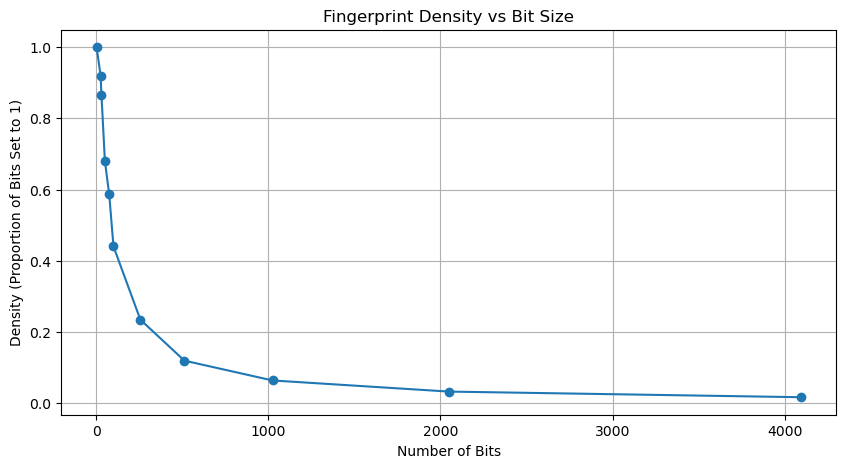

In [6]:
# Convert SMILES to molecule
smiles = "O=C(N[Dy])c1cccc(F)c1Nc1nc(NCc2nccs2)nc(Nc2ccc(Cn3ccnc3)cc2)n1"
mol = Chem.MolFromSmiles(smiles)

# Generate fingerprints with different bit sizes
bit_sizes = [2,25,30,50,75,100,256, 512, 1024, 2048, 4096]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=bits) for bits in bit_sizes]

# Analyze bit density (proportion of bits that are set to 1)
bit_densities = [sum(fp) / len(fp) for fp in fingerprints]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(bit_sizes, bit_densities, marker='o')
plt.title('Fingerprint Density vs Bit Size')
plt.xlabel('Number of Bits')
plt.ylabel('Density (Proportion of Bits Set to 1)')
plt.grid(True)
plt.show()

In [7]:
# Define the two SMILES strings
smiles1 = "O=C(N[Dy])c1cccc(F)c1Nc1nc(Nc2ccc(Cn3ccnc3)cc2)nc(Nc2cc(Cl)c(O)c(Cl)c2)n1"
smiles2 = "O=C(N[Dy])c1cccc(F)c1Nc1nc(Nc2ccc(Cn3ccnc3)cc2)nc(Nc2cc(Cl)c(F)c(Cl)c2)n1"

# Convert SMILES to molecule objects
mol1 = Chem.MolFromSmiles(smiles1)
mol2 = Chem.MolFromSmiles(smiles2)

# Generate the Morgan fingerprints
fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2, nBits=512)
fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2, nBits=512)

# Calculate the Tanimoto similarity between the two fingerprints
similarity = TanimotoSimilarity(fp1, fp2)
print(f"The Tanimoto similarity between the fingerprints is: {similarity}")

The Tanimoto similarity between the fingerprints is: 0.8870967741935484


# Testing Out Data Retrieval

In [8]:
def train_and_evaluate(train_data, test_data):
    conn = connect_to_database()
    if not conn:
        return "Connection failed."

    try:
        cursor = conn.cursor()
        # Assume `prepare_data` fetches and prepares training and testing data
        # Training data
        X_train = [list(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), radius=2, nBits=512))
                   for _, smiles, _, _ in train_data if Chem.MolFromSmiles(smiles)]
        y_train = [binds for _, _, _, binds in train_data if Chem.MolFromSmiles(smiles)]

        # Testing data
        X_test = [list(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), radius=2, nBits=512))
                  for _, smiles, _, _ in test_data if Chem.MolFromSmiles(smiles)]
        y_test = [binds for _, _, _, binds in test_data if Chem.MolFromSmiles(smiles)]

        # Model training
        clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
        clf.fit(X_train, y_train)

        # Evaluate on Training data
        train_matrix, train_report, train_accuracy = evaluate_model(X_train, y_train, clf)
        print(f"Training Confusion Matrix:\n{train_matrix}\n")
        print(f"Training Classification Report:\n{train_report}\n")
        print(f"Training Accuracy: {train_accuracy:.2f}\n")

        # Evaluate on Testing data
        test_matrix, test_report, test_accuracy = evaluate_model(X_test, y_test, clf)
        print(f"Testing Confusion Matrix:\n{test_matrix}\n")
        print(f"Testing Classification Report:\n{test_report}\n")
        print(f"Testing Accuracy: {test_accuracy:.2f}\n")

    finally:
        close_connection(conn)


In [9]:
def prepare_data(cursor):
    """Prepare training and testing datasets."""
    print('Cursor received by prepare_data()...')

    # Create a temporary table to store training IDs
    cursor.execute("""
        CREATE TEMPORARY TABLE IF NOT EXISTS temp_train_ids AS
        SELECT id FROM compounds WHERE binds = 1 ORDER BY id LIMIT 1000000;
    """)
    print('Temporary table for training IDs created...')

    # Fetch the training data using the temporary table
    query_train = """
        SELECT c.id, c.molecule_smiles, c.protein_name, c.binds 
        FROM compounds AS c
        JOIN temp_train_ids AS t ON c.id = t.id;
    """
    cursor.execute(query_train)
    train_pos = cursor.fetchall()
    print('Training data prepared for binds = 1...')

    # Fetch the testing data by excluding IDs in the temporary table
    query_test_positive = """
        SELECT id, molecule_smiles, protein_name, binds 
        FROM compounds 
        WHERE binds = 1 AND id NOT IN (SELECT id FROM temp_train_ids);
    """
    cursor.execute(query_test_positive)
    test_pos = cursor.fetchall()
    print('Testing data prepared for binds = 1...')

    # Count for negative instances
    cursor.execute("SELECT COUNT(*) FROM compounds WHERE binds = 0")
    total_neg = cursor.fetchone()[0]
    neg_sample_size = len(test_pos)  # Ensures balance in the test set
    print(f"Negative sample size for testing determined: {neg_sample_size}...")

    # Fetch negative instances for train and test
    query_neg_train = """
        SELECT id, molecule_smiles, protein_name, binds FROM compounds WHERE binds = 0 LIMIT 1000000;
    """
    cursor.execute(query_neg_train)
    train_neg = cursor.fetchall()
    print('Training data prepared for binds = 0...')

    query_neg_test = f"""
        SELECT id, molecule_smiles, protein_name, binds FROM compounds WHERE binds = 0 LIMIT {neg_sample_size} OFFSET 1000000;
    """
    cursor.execute(query_neg_test)
    test_neg = cursor.fetchall()
    print('Testing data prepared for binds = 0...')

    # Cleanup: drop the temporary table
    cursor.execute("DROP TEMPORARY TABLE IF EXISTS temp_train_ids;")
    print('Temporary table dropped...')

    # Combine and shuffle datasets
    train_data = np.vstack((train_pos, train_neg))
    test_data = np.vstack((test_pos, test_neg))
    np.random.shuffle(train_data)
    np.random.shuffle(test_data)
    print('Data sets shuffled and ready to be returned...')

    return train_data, test_data

In [10]:
def evaluate_model(X, y, clf):
    """Evaluate the model with confusion matrix and classification report."""
    predictions = clf.predict(X)
    conf_matrix = confusion_matrix(y, predictions)
    classif_report = classification_report(y, predictions)
    accuracy = accuracy_score(y, predictions)
    return conf_matrix, classif_report, accuracy

In [11]:
conn = connect_to_database()
try:
    cursor = conn.cursor()
    # Assume `prepare_data` fetches and prepares training and testing data
    train_data, test_data = prepare_data(cursor)
except Error as e:
    print(f"The error '{e}' occurred")
finally:
    close_connection(conn)


Connecting to the MySQL database...
Connection established.
Cursor received by prepare_data()...
Temporary table for training IDs created...
Training data prepared for binds = 1...
Testing data prepared for binds = 1...
Negative sample size for testing determined: 589906...
Training data prepared for binds = 0...
Testing data prepared for binds = 0...
Temporary table dropped...
Data sets shuffled and ready to be returned...
The connection is closed.


In [12]:
# conn = connect_to_database()
# try:
#     cursor = conn.cursor()
#     # Assume `prepare_data` fetches and prepares training and testing data
#     train_and_evaluate(train_data, test_data)
# except Error as e:
#     print(f"The error '{e}' occurred")
# finally:
#     close_connection(conn)


In [ ]:
test_data = pd.DataFrame(test_data)
train_data = pd.DataFrame(train_data)

In [ ]:
test_data.columns = ['ID', 'Mol_SMILES', 'Protein', 'Binds']
train_data.columns = ['ID', 'Mol_SMILES', 'Protein', 'Binds']

In [ ]:
print(train_data['Mol_SMILES'])

In [ ]:
def smiles_to_fingerprint(smiles, radius=2, nBits=512):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
    else:
        return [0]*nBits  # Return a zero vector if the molecule parsing fail
def process_in_batches(smiles_series, batch_size=1000):
    """Process Series in batches to convert SMILES to fingerprints."""
    num_batches = (len(smiles_series) + batch_size - 1) // batch_size  # Calculate number of batches
    results = []  # This will store the final results

    for i in tqdm(range(num_batches), desc="Processing Batches"):
        batch = smiles_series.iloc[i*batch_size:(i+1)*batch_size].apply(smiles_to_fingerprint)
        results.extend(batch)  # Append results directly

    return pd.Series(results)  # Return as a Series


In [ ]:
test_df = pd.DataFrame()
train_df = pd.DataFrame()

train_df['id'] = train_data['ID']
test_df['id'] = test_data['ID']
train_df['binds'] = train_data['Binds']
test_df['binds'] = test_data['Binds']

In [ ]:
# Applying the function to the SMILES column
test_df['molVector'] = process_in_batches(test_data['Mol_SMILES'], batch_size=500)
train_df['molVector'] = process_in_batches(train_data['Mol_SMILES'], batch_size=500)

In [ ]:
def fetch_protein_mapping(cursor):
    """Fetch protein name to numeric mapping from the database."""
    query = "SELECT protein_name, protein_numeric FROM protein_mapping"
    cursor.execute(query)
    mapping_data = cursor.fetchall()
    print('fetched protein mapping...')
    return {name: num for name, num in mapping_data}

conn = connect_to_database()
cursor = conn.cursor()
protein_mapping = fetch_protein_mapping(cursor)

In [ ]:
train_df['Protein_numeric'] = train_data['Protein'].map(protein_mapping)

In [ ]:
test_df['Protein_numeric'] = test_data['Protein'].map(protein_mapping) 